# Comprehensive Contrastive Representation Distillation Experiments
## Full Analysis: SupCon vs SupCRD vs Balanced vs Hybrid

**Goal**: Comprehensive evaluation of contrastive distillation methods with:
- α/β hyperparameter sweeps
- Temperature analysis
- Balanced force normalization
- Pull/push force dynamics
- Semantic similarity validation
- Hybrid loss optimization

**Methods**:
- **Baseline SupCon**: Standard supervised contrastive learning
- **SupCRD**: Logit-weighted representation distillation (α, β tuning)
- **Balanced SupCRD**: Force-normalized variant
- **Hybrid**: Combined SupCon + SupCRD (λ tuning)

---
## Setup & Imports

In [1]:
import json
import os
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from IPython.display import display
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader

# Create directories
os.makedirs("plots", exist_ok=True)
os.makedirs("pth_models", exist_ok=True)
os.makedirs("json_results", exist_ok=True)
os.makedirs("json_results/training_logs", exist_ok=True)
print("✓ Created directories: plots/, pth_models/, json_results/")

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)
print(f"Random seed set to 42 for reproducibility")

✓ Created directories: plots/, pth_models/, json_results/
Using device: cuda
Random seed set to 42 for reproducibility


---
## Hyperparameters

In [2]:
# Training config
BATCH_SIZE = 128
LR = 1e-3
EPOCHS_TEACHER = 10
EPOCHS_STUDENT = 20

# Contrastive config
TEMP = 0.07

# Distillation config (base values)
ALPHA = 1.0
BETA = 10.0

# Sweep ranges
ALPHA_SWEEP = [1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 50.0]
BETA_SWEEP = [1.0, 10.0, 12.0, 20.0, 50.0]
TEMP_SWEEP = [0.05, 0.07, 0.1, 0.15]
LAMBDA_SWEEP = [0.3, 0.5, 0.7, 0.9]

# Dataset config
num_classes = 10
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
          '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe']

print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LR}")
print(f"Temperature: {TEMP}")
print(f"Alpha Sweep: {ALPHA_SWEEP}")
print(f"Beta Sweep: {BETA_SWEEP}")
print(f"Temperature Sweep: {TEMP_SWEEP}")
print(f"Lambda Sweep: {LAMBDA_SWEEP}")

Batch Size: 128
Learning Rate: 0.001
Temperature: 0.07
Alpha Sweep: [1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 50.0]
Beta Sweep: [1.0, 10.0, 12.0, 20.0, 50.0]
Temperature Sweep: [0.05, 0.07, 0.1, 0.15]
Lambda Sweep: [0.3, 0.5, 0.7, 0.9]


---
## Data Loading

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_set)}")
print(f"Test samples: {len(test_set)}")

Train samples: 50000
Test samples: 10000


---
## Model Architecture

In [4]:
class ConvEncoder(nn.Module):
    def __init__(self, feature_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.flat_dim = 128 * 4 * 4
        self.fc = nn.Linear(self.flat_dim, feature_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


class ModelWrapper(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.encoder = ConvEncoder(feature_dim=128)
        self.projector = nn.Sequential(
            nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 64)
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        feats = self.encoder(x)
        proj = self.projector(feats)
        logits = self.classifier(feats)
        return feats, proj, logits


print("✓ Model architecture defined")

✓ Model architecture defined


---
## Loss Functions

In [5]:
class SupConLoss(nn.Module):
    """Baseline Supervised Contrastive Loss"""
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temp = temperature

    def forward(self, student_proj, labels):
        feats = F.normalize(student_proj, dim=1)
        sim_matrix = torch.matmul(feats, feats.T) / self.temp
        labels = labels.view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        logits_mask = torch.scatter(
            torch.ones_like(mask), 1,
            torch.arange(feats.shape[0]).view(-1, 1).to(device), 0
        )
        mask = mask * logits_mask
        logits_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = sim_matrix - logits_max.detach()
        exp_logits = torch.exp(sim_matrix) * logits_mask
        log_prob = sim_matrix - torch.log(exp_logits.sum(1, keepdim=True))
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-8)
        return -mean_log_prob_pos.mean()


class LogitWeightedSupCRDLoss(nn.Module):
    """Logit-Weighted SupCRD with α/β weighting"""
    def __init__(self, alpha=1.0, beta=1.0, temperature=0.07, eps=1e-8):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.tau = temperature
        self.eps = eps

    def forward(self, student_features, teacher_features, teacher_logits, labels):
        batch_size = student_features.shape[0]
        device = student_features.device
        s_norm = F.normalize(student_features, dim=1)
        t_norm = F.normalize(teacher_features, dim=1)
        sim_matrix = torch.matmul(s_norm, t_norm.T) / self.tau
        sim_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = sim_matrix - sim_max.detach()
        exp_sim = torch.exp(sim_matrix)
        teacher_probs = F.softmax(teacher_logits, dim=1)
        labels = labels.view(-1, 1)
        mask_pos = torch.eq(labels, labels.T).float().to(device)
        mask_neg = 1.0 - mask_pos
        p_target = torch.gather(teacher_probs, 1, labels).view(-1)
        w_pull = self.alpha * p_target
        target_labels_expand = labels.view(1, -1).expand(batch_size, -1)
        p_negative_class = torch.gather(teacher_probs, 1, target_labels_expand)
        w_push = self.beta * (1.0 - p_negative_class)
        sum_pos_exp = (exp_sim * mask_pos).sum(dim=1)
        numerator_term = w_pull * sum_pos_exp
        weighted_neg_exp = (exp_sim * w_push * mask_neg).sum(dim=1)
        denominator_term = numerator_term + weighted_neg_exp
        loss = -torch.log((numerator_term + self.eps) / (denominator_term + self.eps))
        return loss.mean()


class BalancedLogitWeightedSupCRDLoss(nn.Module):
    """Balanced SupCRD with automatic force normalization"""
    def __init__(self, alpha=1.0, beta=1.0, temperature=0.07, eps=1e-8):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.tau = temperature
        self.eps = eps

    def forward(self, student_features, teacher_features, teacher_logits, labels):
        batch_size = student_features.shape[0]
        device = student_features.device
        s_norm = F.normalize(student_features, dim=1)
        t_norm = F.normalize(teacher_features, dim=1)
        sim_matrix = torch.matmul(s_norm, t_norm.T) / self.tau
        sim_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = sim_matrix - sim_max.detach()
        exp_sim = torch.exp(sim_matrix)
        labels = labels.view(-1, 1)
        mask_pos = torch.eq(labels, labels.T).float().to(device)
        mask_neg = 1.0 - mask_pos
        teacher_probs = F.softmax(teacher_logits, dim=1)
        p_target = torch.gather(teacher_probs, 1, labels).view(-1)
        w_pull = self.alpha * p_target
        target_labels_expand = labels.view(1, -1).expand(batch_size, -1)
        p_negative_class = torch.gather(teacher_probs, 1, target_labels_expand)
        w_push_raw = self.beta * (1.0 - p_negative_class)
        total_push_mass = (w_push_raw * mask_neg).sum(dim=1)
        norm_factor = w_pull / (total_push_mass + self.eps)
        w_push_balanced = w_push_raw * norm_factor.view(-1, 1)
        sum_pos_exp = (exp_sim * mask_pos).sum(dim=1)
        numerator_term = w_pull * sum_pos_exp
        weighted_neg_exp = (exp_sim * w_push_balanced * mask_neg).sum(dim=1)
        denominator_term = numerator_term + weighted_neg_exp
        loss = -torch.log((numerator_term + self.eps) / (denominator_term + self.eps))
        return loss.mean()


class HybridSupCRDLoss(nn.Module):
    """Hybrid: λ * SupCon + (1-λ) * SupCRD"""
    def __init__(self, alpha=1.0, beta=12.0, lambda_supcon=0.7, temperature=0.07):
        super().__init__()
        self.supcon_loss = SupConLoss(temperature=temperature)
        self.supcrd_loss = LogitWeightedSupCRDLoss(alpha=alpha, beta=beta, temperature=temperature)
        self.lambda_supcon = lambda_supcon
        self.register_buffer("supcon_scale", torch.tensor(1.0))
        self.register_buffer("supcrd_scale", torch.tensor(1.0))
        self.warmup_steps = 100
        self.step_count = 0

    def forward(self, student_proj, teacher_proj, teacher_logits, labels):
        loss_supcon = self.supcon_loss(student_proj, labels)
        loss_supcrd = self.supcrd_loss(student_proj, teacher_proj, teacher_logits, labels)
        if self.step_count < self.warmup_steps:
            self.step_count += 1
            with torch.no_grad():
                self.supcon_scale = 0.9 * self.supcon_scale + 0.1 * loss_supcon.detach()
                self.supcrd_scale = 0.9 * self.supcrd_scale + 0.1 * loss_supcrd.detach()
        loss_supcon_norm = loss_supcon / (self.supcon_scale + 1e-8)
        loss_supcrd_norm = loss_supcrd / (self.supcrd_scale + 1e-8)
        return (self.lambda_supcon * loss_supcon_norm + (1 - self.lambda_supcon) * loss_supcrd_norm)


print("✓ Loss functions defined")

✓ Loss functions defined


---
## Utility Functions

In [6]:
def evaluate_model(model, test_loader, device):
    """Evaluate model accuracy."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            features = model.encoder(images)
            logits = model.classifier(features)
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


def visualize_latents(model, dataloader, device, title="Latent Space", max_samples=1000):
    """Visualize latent space with t-SNE."""
    model.eval()
    latents_list, labels_list = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            if len(latents_list) * images.size(0) >= max_samples:
                break
            images = images.to(device)
            latents = model.encoder(images)
            latents_list.append(latents.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    latents = np.concatenate(latents_list, axis=0)[:max_samples]
    labels = np.concatenate(labels_list, axis=0)[:max_samples]
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    latents_2d = tsne.fit_transform(latents)
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        mask = labels == i
        plt.scatter(latents_2d[mask, 0], latents_2d[mask, 1], 
                   c=[colors[i]], label=class_names[i], 
                   alpha=0.6, s=30, edgecolors='k', linewidth=0.5)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, shadow=True)
    plt.grid(True, alpha=0.3)
    fig = plt.gcf()
    display(fig)
    fig.savefig(f'plots/{title.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)


def compute_semantic_similarities(model, dataloader, device, num_classes=10):
    """Compute class centroid similarities."""
    model.eval()
    class_features = [[] for _ in range(num_classes)]
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            features = model.encoder(images)
            features = F.normalize(features, dim=1)
            for i in range(num_classes):
                mask = labels == i
                if mask.any():
                    class_features[i].append(features[mask])
    centroids = []
    for i in range(num_classes):
        if class_features[i]:
            centroid = torch.cat(class_features[i], dim=0).mean(dim=0)
            centroids.append(F.normalize(centroid.unsqueeze(0), dim=1))
        else:
            centroids.append(torch.zeros(1, 128, device=device))
    centroids = torch.cat(centroids, dim=0)
    return torch.mm(centroids, centroids.t()).cpu().numpy()


def compare_semantic_structure(baseline_sim, method_sim, class_names, method_name=""):
    """Compare semantic similarities."""
    pairs = [('dog', 'cat', 'high'), ('dog', 'deer', 'high'), 
             ('dog', 'car', 'low'), ('dog', 'truck', 'low'),
             ('plane', 'ship', 'mid'), ('plane', 'bird', 'mid')]
    print(f"\n{'='*90}")
    print(f"SEMANTIC SIMILARITY: {method_name}")
    print("="*90)
    print(f"{'Pair':<15} | {'Baseline':<10} | {'Method':<10} | {'Δ Abs':<10} | {'Δ %':<10} | {'Quality'}")
    print("-"*90)
    name_to_idx = {name: idx for idx, name in enumerate(class_names)}
    for class1, class2, expected in pairs:
        idx1, idx2 = name_to_idx[class1], name_to_idx[class2]
        base_val = baseline_sim[idx1, idx2]
        method_val = method_sim[idx1, idx2]
        delta_abs = method_val - base_val
        delta_pct = (delta_abs / abs(base_val)) * 100 if base_val != 0 else 0
        if expected == 'high':
            quality = "✓" if delta_abs > 0 else "✗"
            desire = "↑"
        elif expected == 'low':
            quality = "✓" if delta_abs < 0 else "✗"
            desire = "↓"
        else:
            quality = "○"
            desire = "~"
        pair_name = f"{class1}-{class2}"
        print(f"{pair_name:<15} | {base_val:>9.4f} | {method_val:>9.4f} | "
              f"{delta_abs:>+9.4f} | {delta_pct:>+8.1f}% | {quality} (want {desire})")
    print("="*90)


def save_training_log(log_data, filename):
    """Save training log to JSON."""
    with open(f'json_results/training_logs/{filename}.json', 'w') as f:
        json.dump(log_data, f, indent=2)


def load_training_log(filename):
    """Load training log from JSON."""
    path = f'json_results/training_logs/{filename}.json'
    if os.path.exists(path):
        with open(path, 'r') as f:
            return json.load(f)
    return None


print("✓ Utility functions defined")

✓ Utility functions defined


---
## Training Functions

In [7]:
def train_teacher(teacher, train_loader, optimizer, criterion, device, epochs=10, log_name=None):
    """Train teacher with logging."""
    print(f"\n{'='*60}")
    print(f"TRAINING TEACHER MODEL ({epochs} epochs)")
    print(f"{'='*60}")
    
    training_log = {'epochs': [], 'train_loss': [], 'train_acc': []}
    teacher.train()
    
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            _, _, logits = teacher(images)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        avg_loss = total_loss / len(train_loader)
        acc = 100. * correct / total
        print(f"Epoch {epoch+1:2d}/{epochs}: Loss={avg_loss:.3f} | Acc={acc:.1f}%")
        
        training_log['epochs'].append(epoch + 1)
        training_log['train_loss'].append(avg_loss)
        training_log['train_acc'].append(acc)
    
    if log_name:
        save_training_log(training_log, log_name)
    
    print(f"\n✓ Teacher training complete: {acc:.1f}% accuracy\n")
    return teacher, training_log


def train_student(teacher, student, train_loader, optimizer, criterion, 
                 device, epochs=20, label="", mode="supcrd", log_name=None):
    """Train student with logging."""
    print(f"\n{'='*60}")
    print(f"TRAINING: {label} (mode={mode})")
    print(f"{'='*60}\n")
    
    teacher.eval()
    student.train()
    
    linear_classifier = nn.Linear(128, 10).to(device)
    classifier_opt = torch.optim.Adam(linear_classifier.parameters(), lr=LR)
    classifier_criterion = nn.CrossEntropyLoss()
    
    training_log = {'epochs': [], 'contrastive_loss': [], 'train_acc': []}
    
    for epoch in range(epochs):
        total_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels_batch in train_loader:
            images, labels_batch = images.to(device), labels_batch.to(device)
            optimizer.zero_grad()
            
            with torch.no_grad():
                teacher_features = teacher.encoder(images)
                teacher_proj = teacher.projector(teacher_features)
                teacher_logits = teacher.classifier(teacher_features)
            
            student_features = student.encoder(images)
            student_proj = student.projector(student_features)
            
            if mode == 'supcon':
                loss = criterion(student_proj, labels_batch)
            elif mode in ['supcrd', 'hybrid', 'balanced']:
                loss = criterion(student_proj, teacher_proj, teacher_logits, labels_batch)
            else:
                raise ValueError(f"Unknown mode: {mode}")
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            with torch.no_grad():
                frozen_features = student.encoder(images)
            logits = linear_classifier(frozen_features)
            clf_loss = classifier_criterion(logits, labels_batch)
            classifier_opt.zero_grad()
            clf_loss.backward()
            classifier_opt.step()
            
            _, predicted = logits.max(1)
            total += labels_batch.size(0)
            correct += predicted.eq(labels_batch).sum().item()
        
        avg_loss = total_loss / len(train_loader)
        acc = 100. * correct / total
        print(f"  [{label}] Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Acc: {acc:.1f}%")
        
        training_log['epochs'].append(epoch + 1)
        training_log['contrastive_loss'].append(avg_loss)
        training_log['train_acc'].append(acc)
    
    student.classifier.load_state_dict(linear_classifier.state_dict())
    
    if log_name:
        save_training_log(training_log, log_name)
    
    print(f"\n✓ {label} training complete\n")
    return student, training_log


print("✓ Training functions defined")

✓ Training functions defined


---
## EXPERIMENT 1: Train Teacher

Loading teacher from pth_models/teacher.pth
  Train Acc (final): 88.28%

Teacher Test Accuracy: 75.58%

📊 Visualizing teacher's latent space...


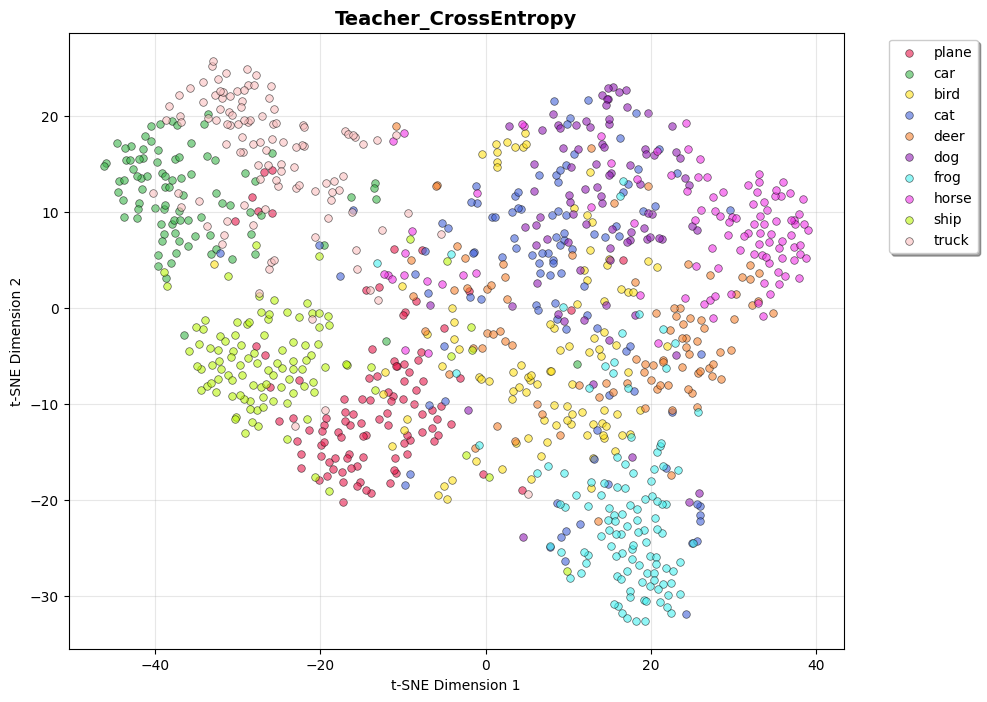

✓ Teacher visualization complete



In [8]:
FORCE_RETRAIN_TEACHER = False
teacher_model_path = "pth_models/teacher.pth"

teacher_log = load_training_log("teacher")
if os.path.exists(teacher_model_path) and not FORCE_RETRAIN_TEACHER and teacher_log:
    print(f"Loading teacher from {teacher_model_path}")
    teacher = ModelWrapper(num_classes=num_classes).to(device)
    teacher.load_state_dict(torch.load(teacher_model_path, map_location=device))
    print(f"  Train Acc (final): {teacher_log['train_acc'][-1]:.2f}%")
else:
    teacher = ModelWrapper(num_classes=num_classes).to(device)
    optimizer_teacher = torch.optim.Adam(teacher.parameters(), lr=LR)
    criterion_teacher = nn.CrossEntropyLoss()
    teacher, teacher_log = train_teacher(
        teacher,
        train_loader,
        optimizer_teacher,
        criterion_teacher,
        device,
        epochs=EPOCHS_TEACHER,
        log_name="teacher",
    )
    torch.save(teacher.state_dict(), teacher_model_path)

acc_teacher = evaluate_model(teacher, test_loader, device)
print(f"\n{'='*50}")
print(f"Teacher Test Accuracy: {acc_teacher:.2f}%")
print(f"{'='*50}\n")

# Visualize teacher's latent space
print("📊 Visualizing teacher's latent space...")
visualize_latents(teacher, test_loader, device, title="Teacher_CrossEntropy")
print("✓ Teacher visualization complete\n")

---
## EXPERIMENT 2: Baseline SupCon

Loading baseline from pth_models/student_baseline_supcon.pth
  Train Acc (final): 93.39%

Baseline SupCon Test Accuracy: 73.36%



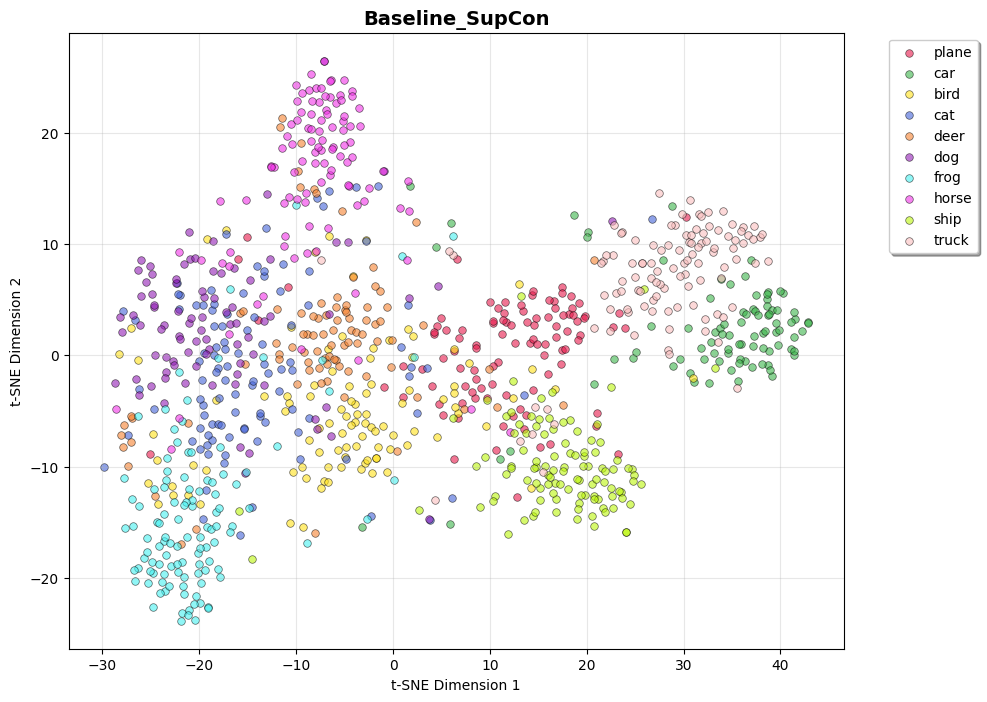

In [9]:
FORCE_RETRAIN_BASELINE = False
baseline_model_path = 'pth_models/student_baseline_supcon.pth'

baseline_log = load_training_log('baseline_supcon')
if os.path.exists(baseline_model_path) and not FORCE_RETRAIN_BASELINE and baseline_log:
    print(f"Loading baseline from {baseline_model_path}")
    student_baseline = ModelWrapper(num_classes=num_classes).to(device)
    student_baseline.load_state_dict(torch.load(baseline_model_path, map_location=device))
    print(f"  Train Acc (final): {baseline_log['train_acc'][-1]:.2f}%")
else:
    student_baseline = ModelWrapper(num_classes=num_classes).to(device)
    optimizer_baseline = torch.optim.Adam(student_baseline.parameters(), lr=LR)
    criterion_baseline = SupConLoss(temperature=TEMP)
    student_baseline, baseline_log = train_student(
        teacher, student_baseline, train_loader, optimizer_baseline,
        criterion_baseline, device, epochs=EPOCHS_STUDENT,
        label="Baseline_SupCon", mode='supcon', log_name='baseline_supcon'
    )
    torch.save(student_baseline.state_dict(), baseline_model_path)

acc_baseline = evaluate_model(student_baseline, test_loader, device)
print(f"\n{'='*50}")
print(f"Baseline SupCon Test Accuracy: {acc_baseline:.2f}%")
print(f"{'='*50}\n")

visualize_latents(student_baseline, test_loader, device, title="Baseline_SupCon")

---
## EXPERIMENT 3: Alpha Sweep (β=1 fixed)


ALPHA SWEEP (β=1 fixed)

Loading SupCRD (α=1.0, β=1) from pth_models/student_supcrd_a1.0_b1.pth
  Train Acc (final): 89.44%
  ✓ α=1.0: 73.95% (vs baseline: +0.59%)


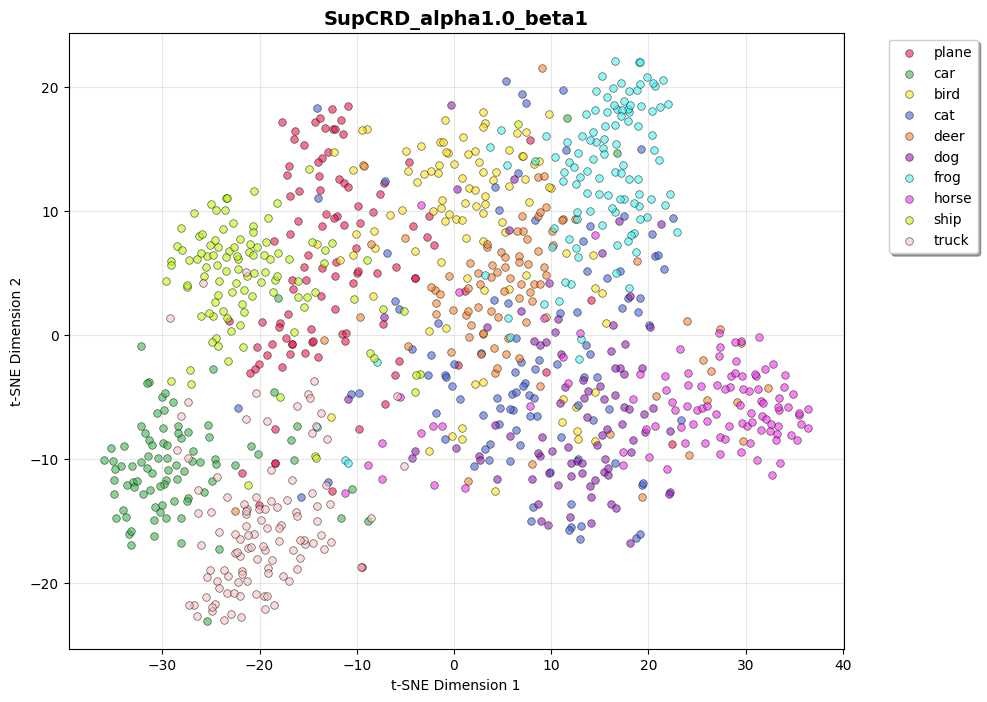


Loading SupCRD (α=2.0, β=1) from pth_models/student_supcrd_a2.0_b1.pth
  Train Acc (final): 89.95%
  ✓ α=2.0: 75.38% (vs baseline: +2.02%)


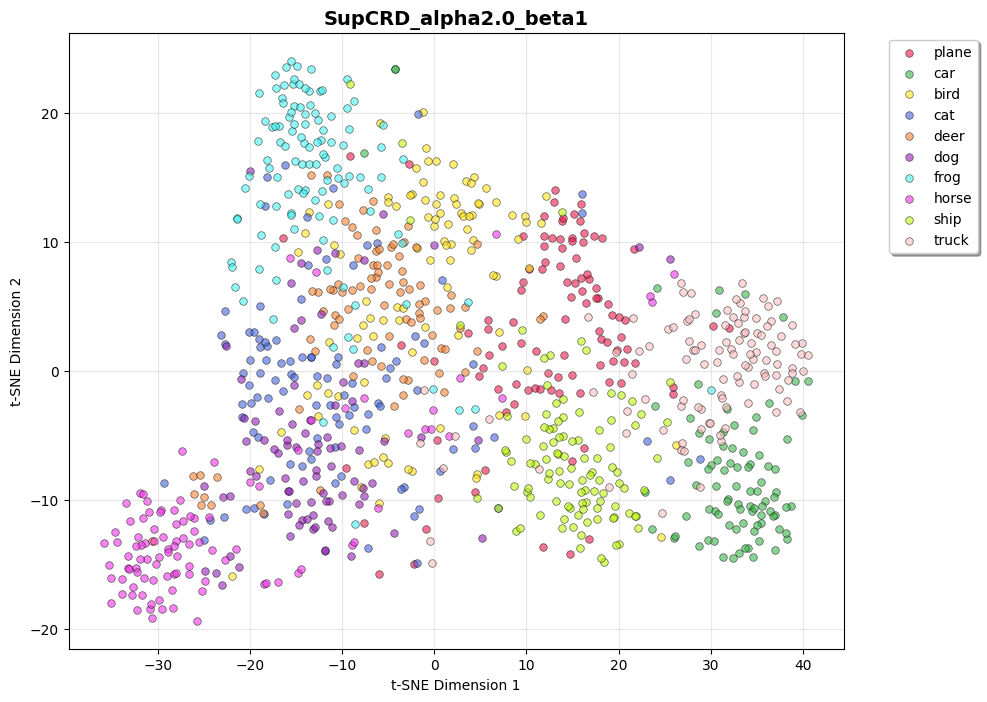


Loading SupCRD (α=3.0, β=1) from pth_models/student_supcrd_a3.0_b1.pth
  Train Acc (final): 88.87%
  ✓ α=3.0: 74.42% (vs baseline: +1.06%)


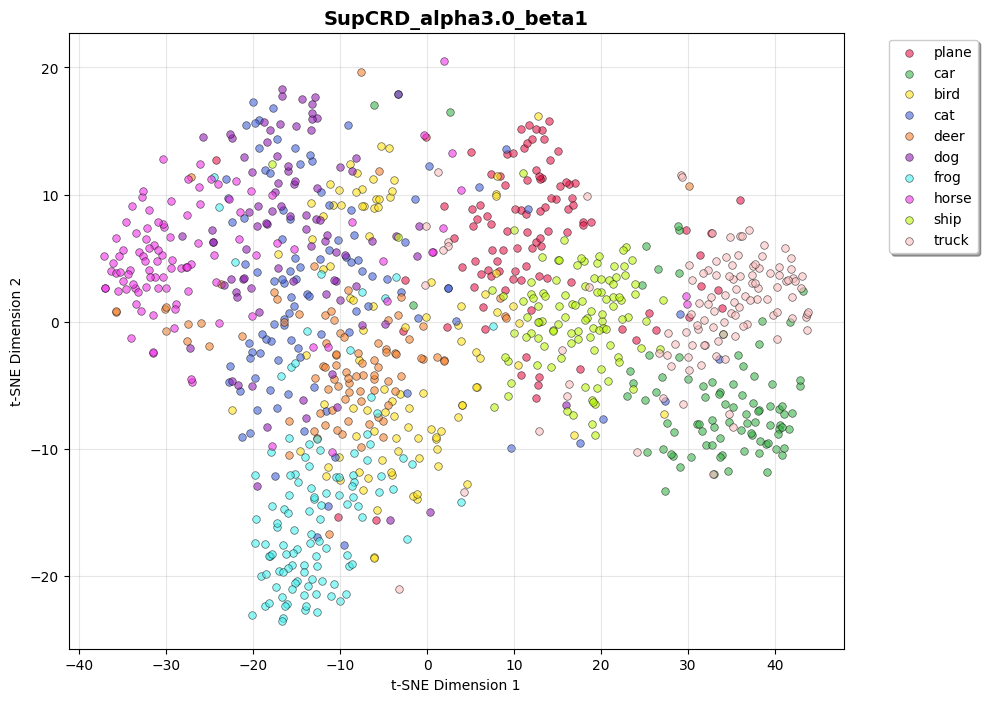


Loading SupCRD (α=4.0, β=1) from pth_models/student_supcrd_a4.0_b1.pth
  Train Acc (final): 89.32%
  ✓ α=4.0: 74.32% (vs baseline: +0.96%)


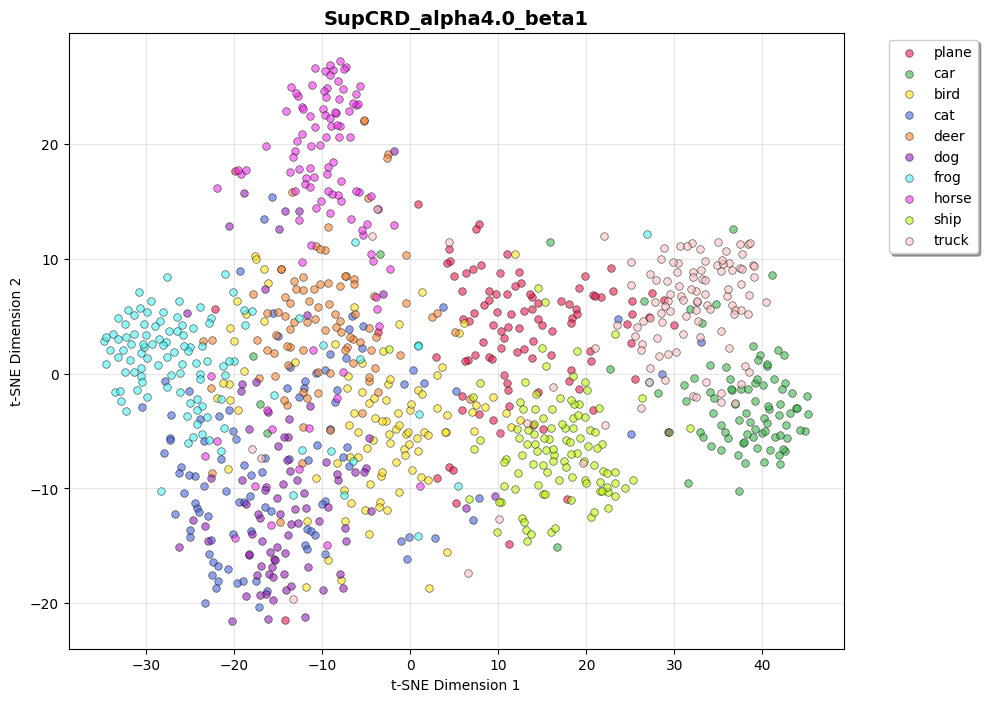


Loading SupCRD (α=5.0, β=1) from pth_models/student_supcrd_a5.0_b1.pth
  Train Acc (final): 88.27%
  ✓ α=5.0: 73.91% (vs baseline: +0.55%)


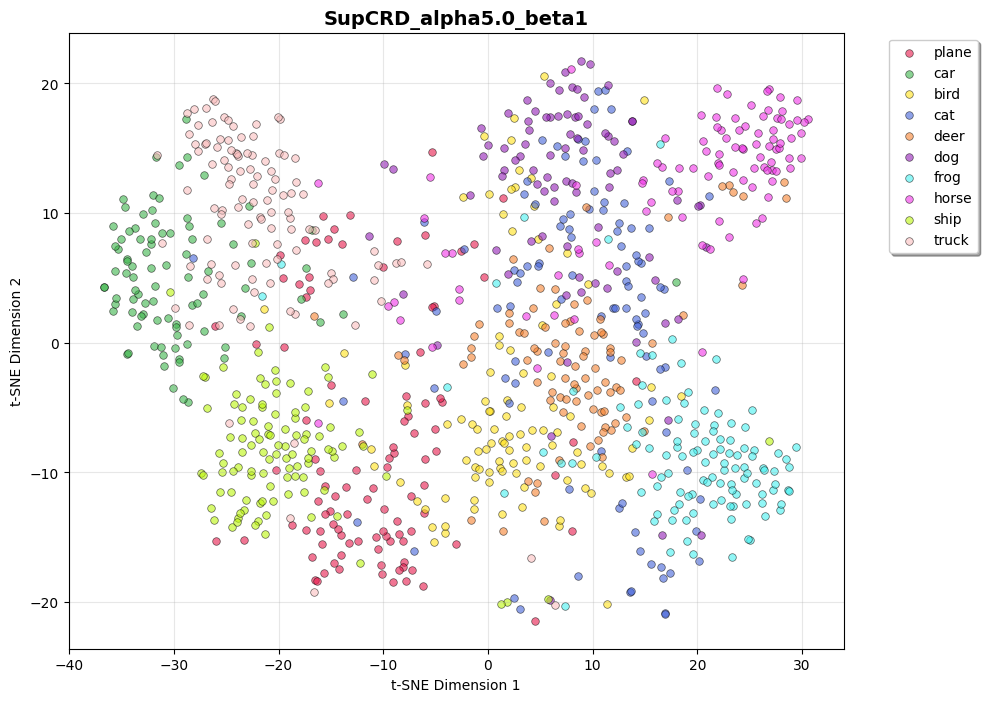


Loading SupCRD (α=10.0, β=1) from pth_models/student_supcrd_a10.0_b1.pth
  Train Acc (final): 85.88%
  ✓ α=10.0: 72.55% (vs baseline: -0.81%)


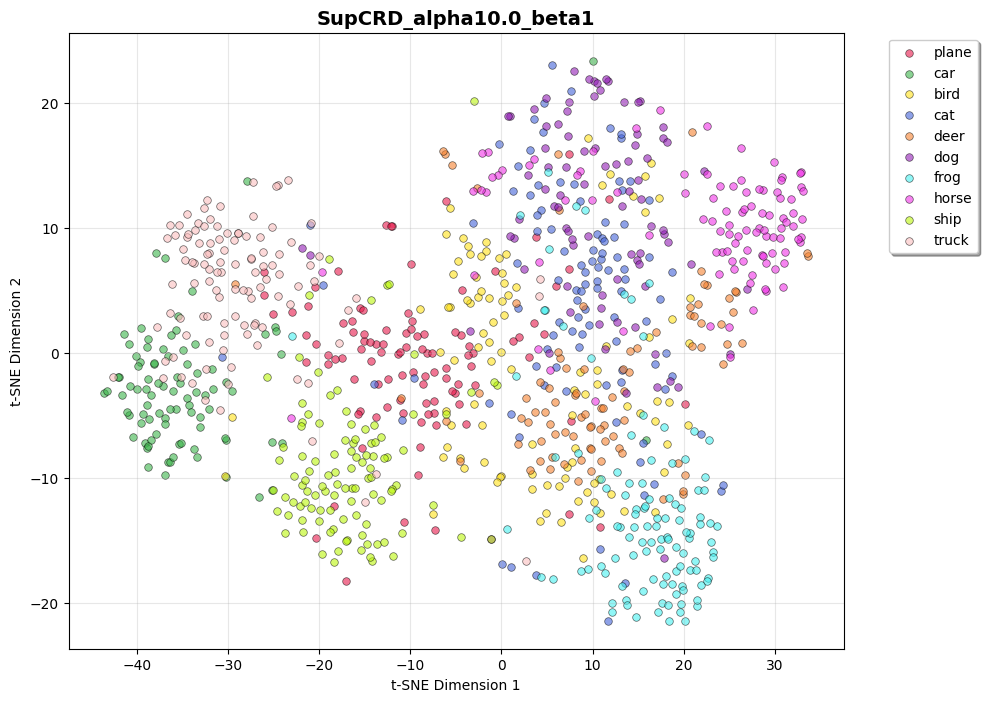


Loading SupCRD (α=50.0, β=1) from pth_models/student_supcrd_a50.0_b1.pth
  Train Acc (final): 83.00%
  ✓ α=50.0: 74.09% (vs baseline: +0.73%)


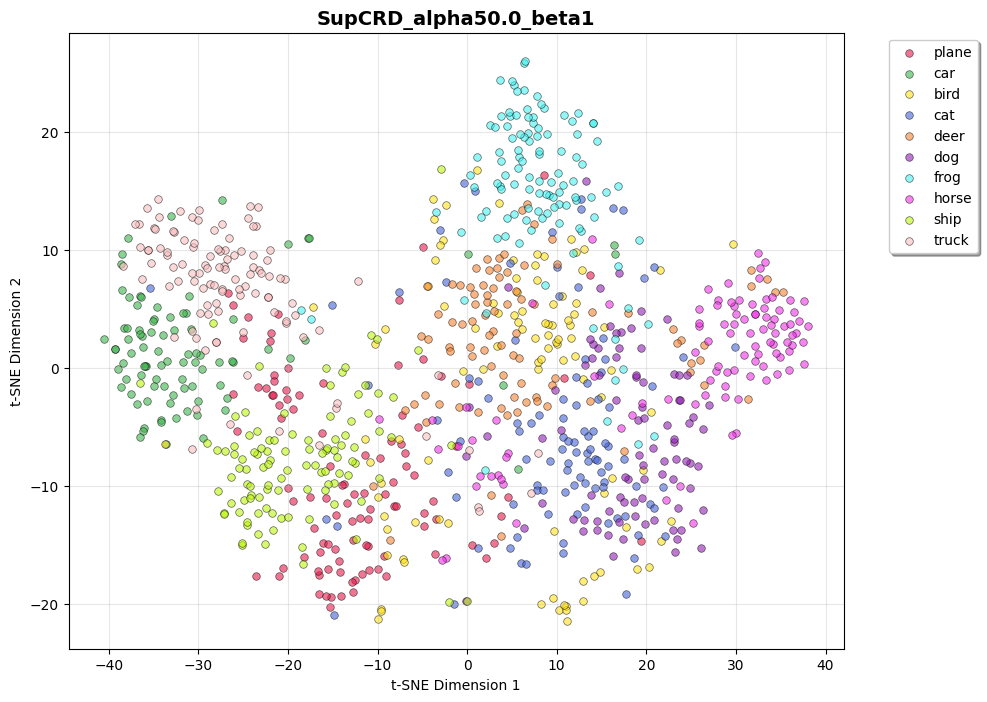


ALPHA SWEEP SUMMARY
α=1.0  :  73.95% ( +0.59%) ✓
α=2.0  :  75.38% ( +2.02%) ✓
α=3.0  :  74.42% ( +1.06%) ✓
α=4.0  :  74.32% ( +0.96%) ✓
α=5.0  :  73.91% ( +0.55%) ✓
α=10.0 :  72.55% ( -0.81%) ✗
α=50.0 :  74.09% ( +0.73%) ✓


In [10]:
FORCE_RETRAIN_ALPHA = False
alpha_results = {}

print("\n" + "="*100)
print("ALPHA SWEEP (β=1 fixed)")
print("="*100)

for alpha_val in ALPHA_SWEEP:
    model_path = f'pth_models/student_supcrd_a{alpha_val}_b1.pth'
    log_name = f'supcrd_a{alpha_val}_b1'
    
    alpha_log = load_training_log(log_name)
    if os.path.exists(model_path) and not FORCE_RETRAIN_ALPHA and alpha_log:
        print(f"\nLoading SupCRD (α={alpha_val}, β=1) from {model_path}")
        student = ModelWrapper(num_classes=num_classes).to(device)
        student.load_state_dict(torch.load(model_path, map_location=device))
        print(f"  Train Acc (final): {alpha_log['train_acc'][-1]:.2f}%")
    else:
        student = ModelWrapper(num_classes=num_classes).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=LR)
        criterion = LogitWeightedSupCRDLoss(alpha=alpha_val, beta=1.0, temperature=TEMP)
        student, alpha_log = train_student(
            teacher, student, train_loader, optimizer, criterion, device,
            epochs=EPOCHS_STUDENT, label=f"SupCRD_α{alpha_val}_β1",
            mode='supcrd', log_name=log_name
        )
        torch.save(student.state_dict(), model_path)
    
    acc = evaluate_model(student, test_loader, device)
    alpha_results[alpha_val] = acc
    print(f"  ✓ α={alpha_val}: {acc:.2f}% (vs baseline: {acc - acc_baseline:+.2f}%)")
    visualize_latents(student, test_loader, device, title=f"SupCRD_alpha{alpha_val}_beta1")

print("\n" + "="*100)
print("ALPHA SWEEP SUMMARY")
print("="*100)
for alpha_val in sorted(alpha_results.keys()):
    acc = alpha_results[alpha_val]
    delta = acc - acc_baseline
    symbol = "✓" if acc > acc_baseline else "✗"
    print(f"α={alpha_val:<5}: {acc:>6.2f}% ({delta:>+6.2f}%) {symbol}")
print("="*100)

---
## EXPERIMENT 4: Beta Sweep (α=1 fixed)


BETA SWEEP (α=1 fixed)

Loading SupCRD (α=1, β=1.0) from pth_models/student_supcrd_a1_b1.0.pth
  Train Acc (final): 89.91%
  ✓ β=1.0: 75.19% (vs baseline: +1.83%)


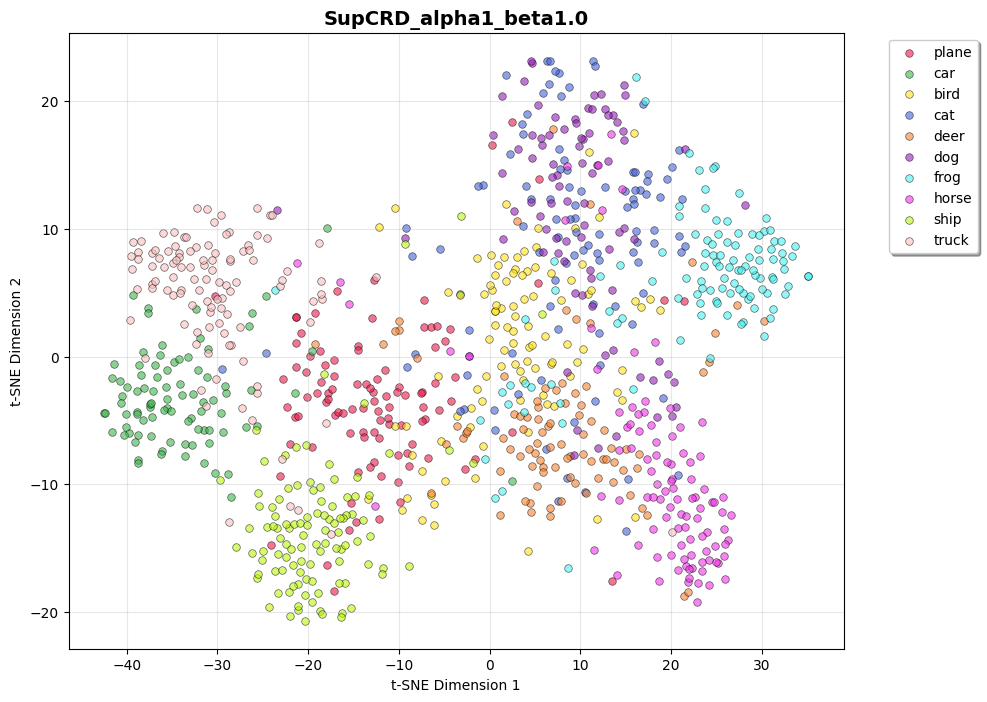


Loading SupCRD (α=1, β=10.0) from pth_models/student_supcrd_a1_b10.0.pth
  Train Acc (final): 90.50%
  ✓ β=10.0: 74.64% (vs baseline: +1.28%)


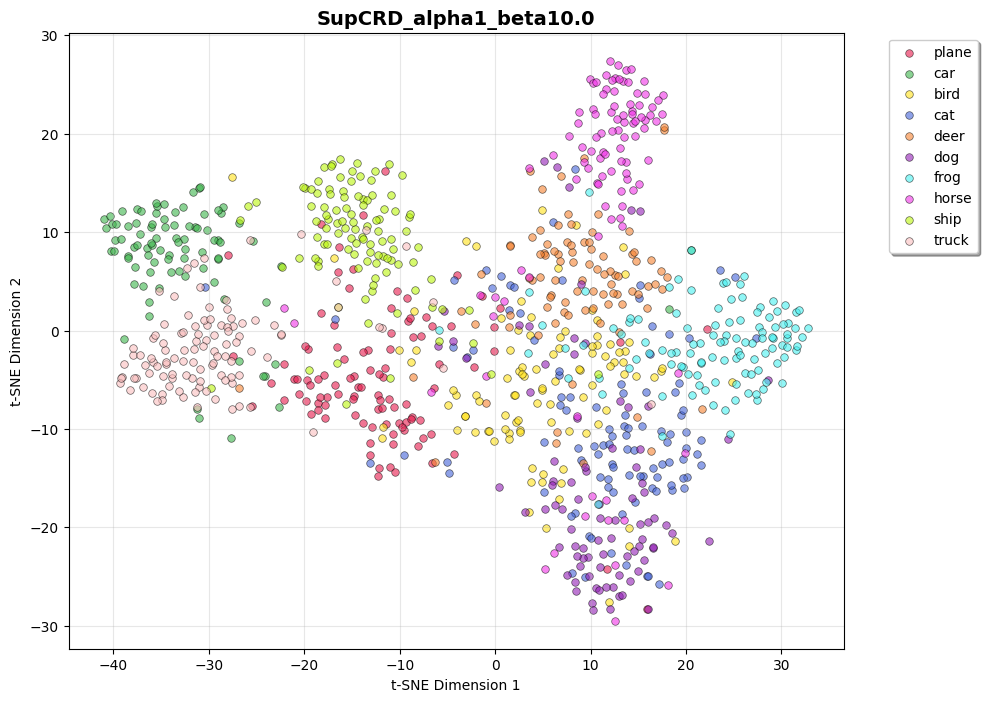


Loading SupCRD (α=1, β=12.0) from pth_models/student_supcrd_a1_b12.0.pth
  Train Acc (final): 90.81%
  ✓ β=12.0: 74.62% (vs baseline: +1.26%)


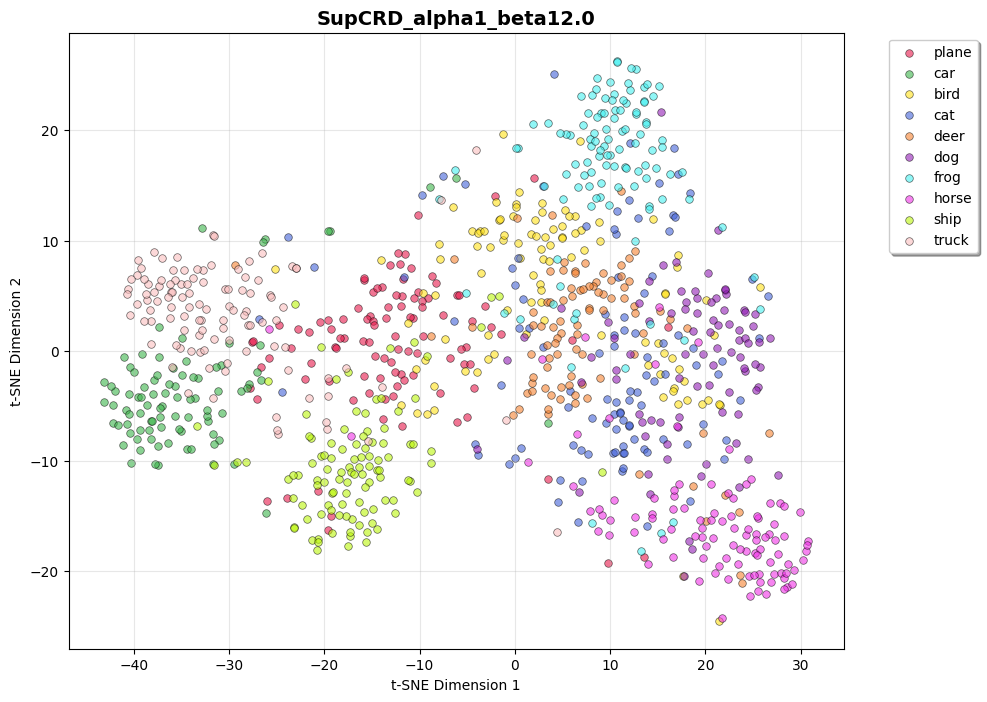


Loading SupCRD (α=1, β=20.0) from pth_models/student_supcrd_a1_b20.0.pth
  Train Acc (final): 90.67%
  ✓ β=20.0: 74.60% (vs baseline: +1.24%)


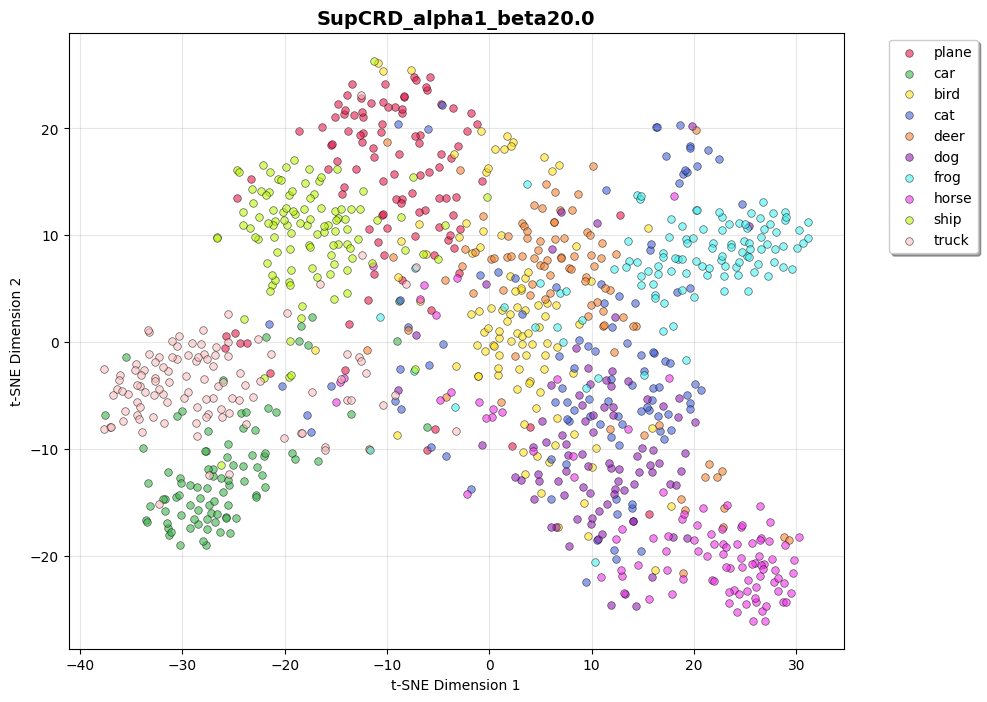


Loading SupCRD (α=1, β=50.0) from pth_models/student_supcrd_a1_b50.0.pth
  Train Acc (final): 89.82%
  ✓ β=50.0: 74.84% (vs baseline: +1.48%)


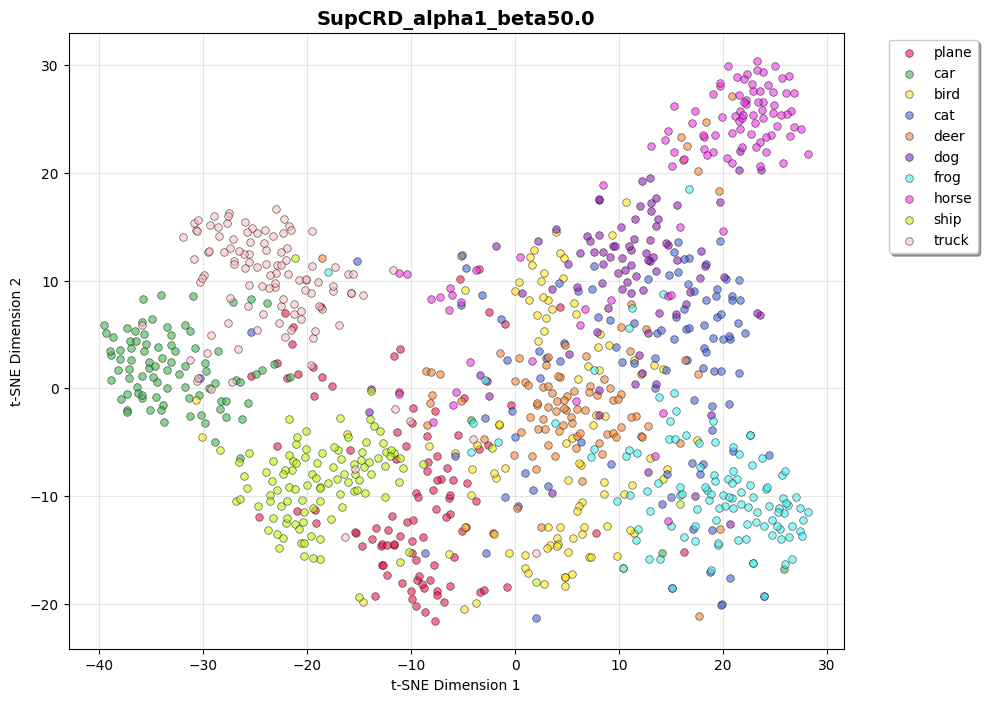


BETA SWEEP SUMMARY
β=1.0  :  75.19% ( +1.83%) ✓
β=10.0 :  74.64% ( +1.28%) ✓
β=12.0 :  74.62% ( +1.26%) ✓
β=20.0 :  74.60% ( +1.24%) ✓
β=50.0 :  74.84% ( +1.48%) ✓


In [11]:
FORCE_RETRAIN_BETA = False
beta_results = {}
beta_models = {}  # Store for later analysis

print("\n" + "="*100)
print("BETA SWEEP (α=1 fixed)")
print("="*100)

for beta_val in BETA_SWEEP:
    model_path = f'pth_models/student_supcrd_a1_b{beta_val}.pth'
    log_name = f'supcrd_a1_b{beta_val}'
    
    beta_log = load_training_log(log_name)
    if os.path.exists(model_path) and not FORCE_RETRAIN_BETA and beta_log:
        print(f"\nLoading SupCRD (α=1, β={beta_val}) from {model_path}")
        student = ModelWrapper(num_classes=num_classes).to(device)
        student.load_state_dict(torch.load(model_path, map_location=device))
        print(f"  Train Acc (final): {beta_log['train_acc'][-1]:.2f}%")
    else:
        student = ModelWrapper(num_classes=num_classes).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=LR)
        criterion = LogitWeightedSupCRDLoss(alpha=1.0, beta=beta_val, temperature=TEMP)
        student, beta_log = train_student(
            teacher, student, train_loader, optimizer, criterion, device,
            epochs=EPOCHS_STUDENT, label=f"SupCRD_α1_β{beta_val}",
            mode='supcrd', log_name=log_name
        )
        torch.save(student.state_dict(), model_path)
    
    acc = evaluate_model(student, test_loader, device)
    beta_results[beta_val] = acc
    beta_models[beta_val] = student
    print(f"  ✓ β={beta_val}: {acc:.2f}% (vs baseline: {acc - acc_baseline:+.2f}%)")
    visualize_latents(student, test_loader, device, title=f"SupCRD_alpha1_beta{beta_val}")

print("\n" + "="*100)
print("BETA SWEEP SUMMARY")
print("="*100)
for beta_val in sorted(beta_results.keys()):
    acc = beta_results[beta_val]
    delta = acc - acc_baseline
    symbol = "✓" if acc > acc_baseline else "✗"
    print(f"β={beta_val:<5}: {acc:>6.2f}% ({delta:>+6.2f}%) {symbol}")
print("="*100)

---
## EXPERIMENT 5: Balanced SupCRD

Loading Balanced SupCRD from pth_models/student_balanced_supcrd.pth
  Train Acc (final): 82.82%

Balanced SupCRD Test Accuracy: 74.11%
vs Baseline: +0.75%



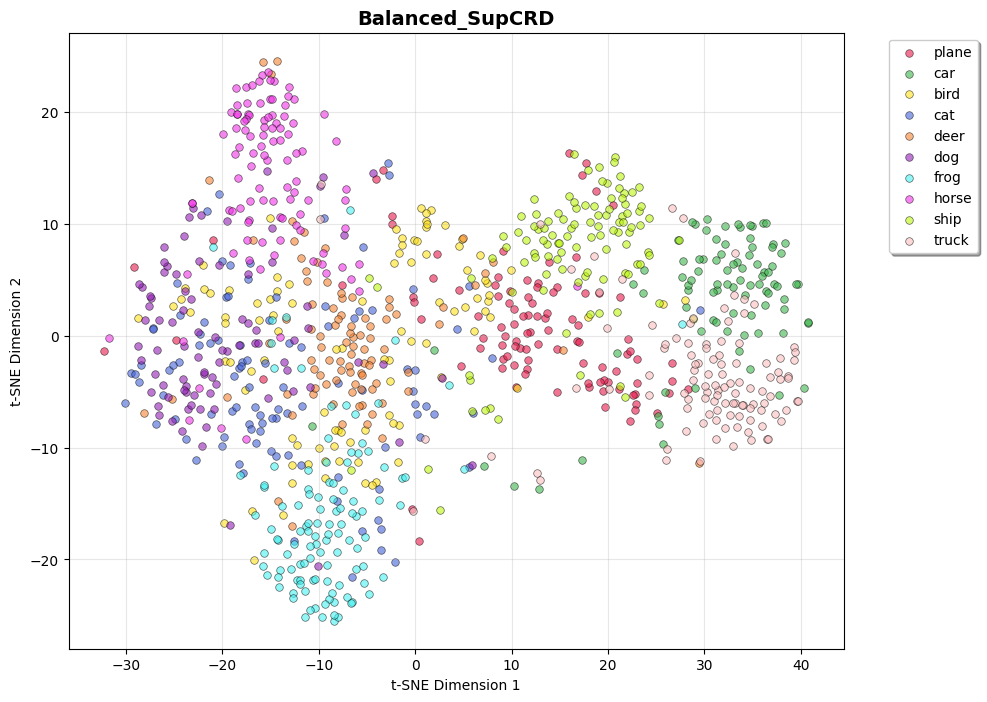

In [12]:
FORCE_RETRAIN_BALANCED = False
balanced_model_path = 'pth_models/student_balanced_supcrd.pth'

balanced_log = load_training_log('balanced_supcrd')
if os.path.exists(balanced_model_path) and not FORCE_RETRAIN_BALANCED and balanced_log:
    print(f"Loading Balanced SupCRD from {balanced_model_path}")
    student_balanced = ModelWrapper(num_classes=num_classes).to(device)
    student_balanced.load_state_dict(torch.load(balanced_model_path, map_location=device))
    print(f"  Train Acc (final): {balanced_log['train_acc'][-1]:.2f}%")
else:
    student_balanced = ModelWrapper(num_classes=num_classes).to(device)
    optimizer_balanced = torch.optim.Adam(student_balanced.parameters(), lr=LR)
    criterion_balanced = BalancedLogitWeightedSupCRDLoss(alpha=1.0, beta=1.0, temperature=TEMP)
    student_balanced, balanced_log = train_student(
        teacher, student_balanced, train_loader, optimizer_balanced,
        criterion_balanced, device, epochs=EPOCHS_STUDENT,
        label="Balanced_SupCRD", mode='balanced', log_name='balanced_supcrd'
    )
    torch.save(student_balanced.state_dict(), balanced_model_path)

acc_balanced = evaluate_model(student_balanced, test_loader, device)
print(f"\n{'='*50}")
print(f"Balanced SupCRD Test Accuracy: {acc_balanced:.2f}%")
print(f"vs Baseline: {acc_balanced - acc_baseline:+.2f}%")
print(f"{'='*50}\n")

visualize_latents(student_balanced, test_loader, device, title="Balanced_SupCRD")

---
## EXPERIMENT 6: Temperature Sweep (α=1, β=12)


TEMPERATURE SWEEP (α=1, β=12 fixed)

Loading SupCRD (τ=0.05) from pth_models/student_supcrd_temp0.05.pth
  Train Acc (final): 89.54%
  ✓ τ=0.05: 75.66% (vs baseline: +2.30%)


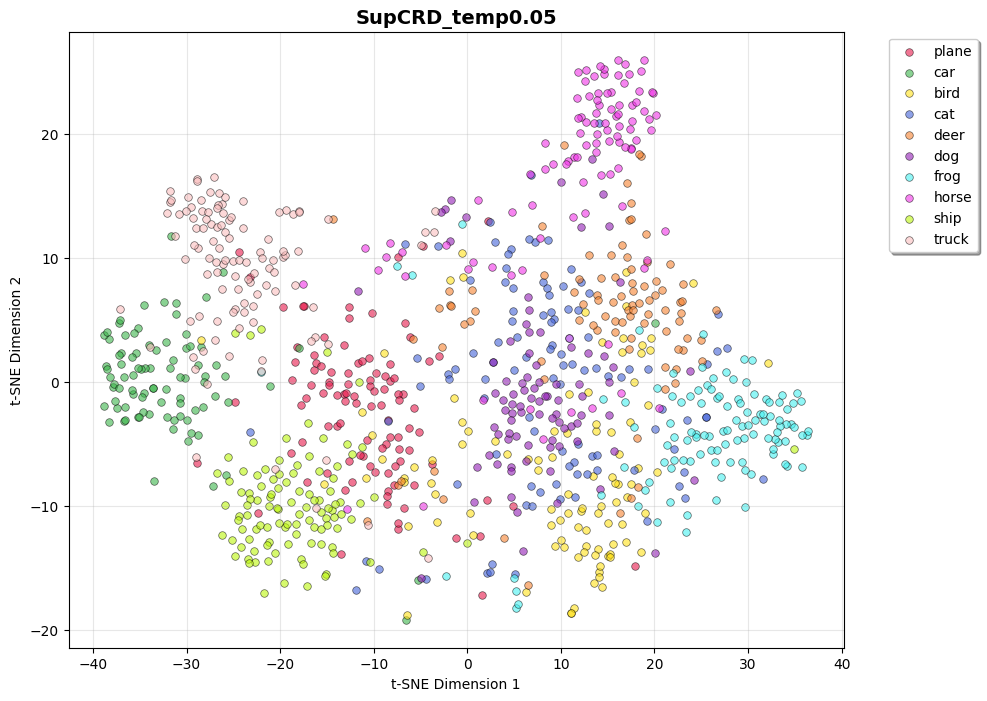


Loading SupCRD (τ=0.07) from pth_models/student_supcrd_temp0.07.pth
  Train Acc (final): 91.27%
  ✓ τ=0.07: 75.62% (vs baseline: +2.26%)


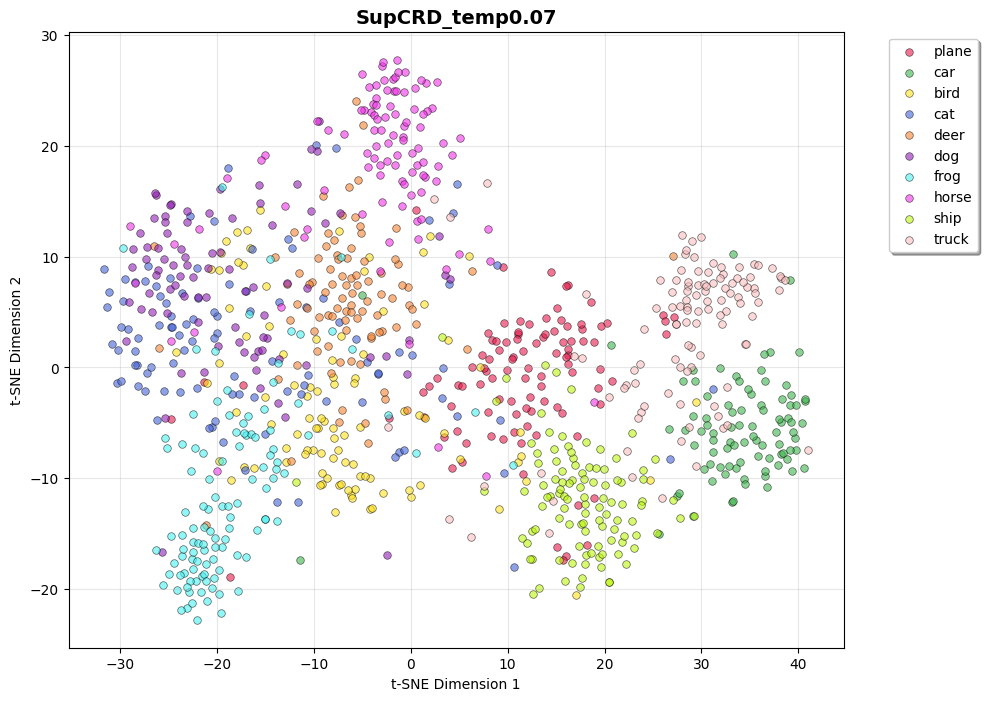


Loading SupCRD (τ=0.1) from pth_models/student_supcrd_temp0.1.pth
  Train Acc (final): 89.98%
  ✓ τ=0.1: 75.34% (vs baseline: +1.98%)


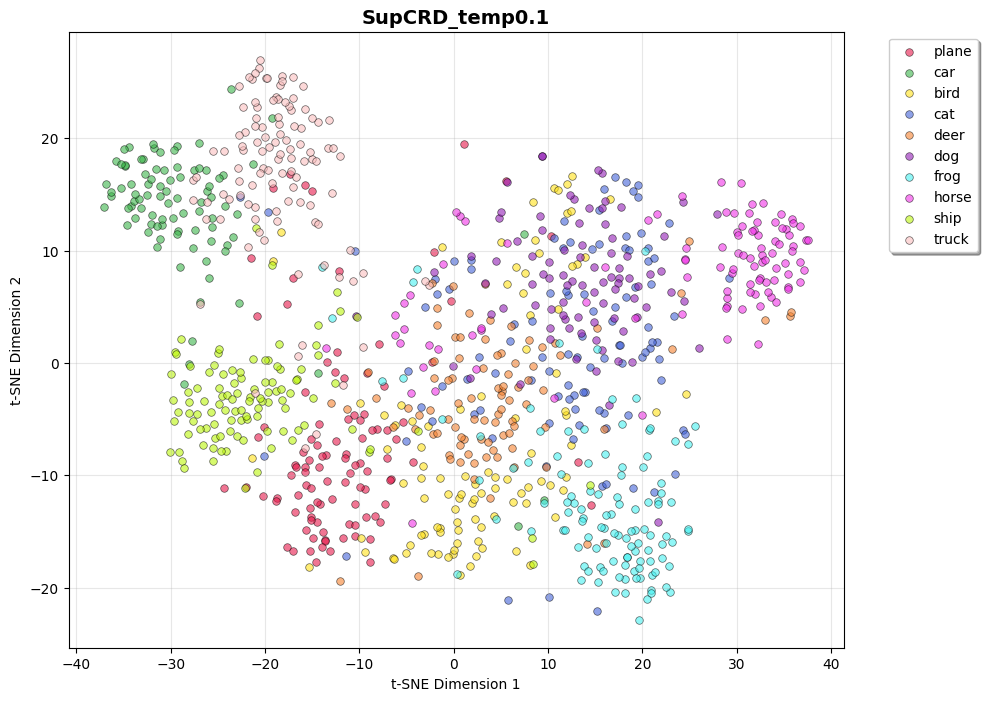


Loading SupCRD (τ=0.15) from pth_models/student_supcrd_temp0.15.pth
  Train Acc (final): 90.11%
  ✓ τ=0.15: 75.02% (vs baseline: +1.66%)


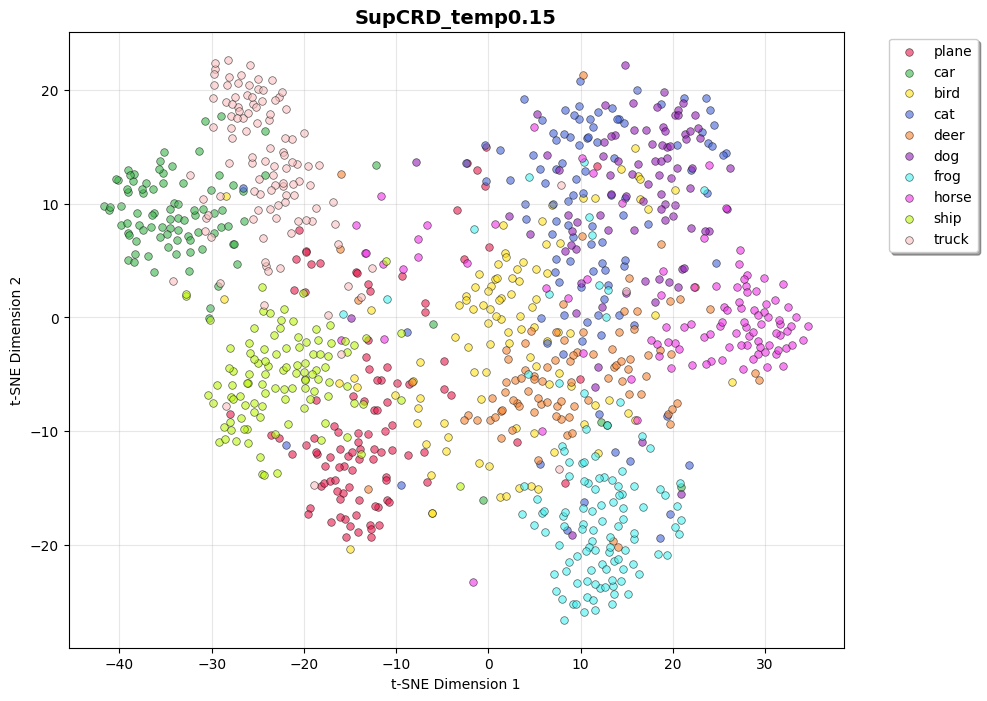


TEMPERATURE SWEEP SUMMARY
τ=0.05 :  75.66% ( +2.30%) ✓
τ=0.07 :  75.62% ( +2.26%) ✓
τ=0.1  :  75.34% ( +1.98%) ✓
τ=0.15 :  75.02% ( +1.66%) ✓


In [13]:
FORCE_RETRAIN_TEMP = False
temp_results = {}

print("\n" + "="*100)
print("TEMPERATURE SWEEP (α=1, β=12 fixed)")
print("="*100)

for temp_val in TEMP_SWEEP:
    model_path = f'pth_models/student_supcrd_temp{temp_val}.pth'
    log_name = f'supcrd_temp{temp_val}'
    
    temp_log = load_training_log(log_name)
    if os.path.exists(model_path) and not FORCE_RETRAIN_TEMP and temp_log:
        print(f"\nLoading SupCRD (τ={temp_val}) from {model_path}")
        student = ModelWrapper(num_classes=num_classes).to(device)
        student.load_state_dict(torch.load(model_path, map_location=device))
        print(f"  Train Acc (final): {temp_log['train_acc'][-1]:.2f}%")
    else:
        student = ModelWrapper(num_classes=num_classes).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=LR)
        criterion = LogitWeightedSupCRDLoss(alpha=1.0, beta=12.0, temperature=temp_val)
        student, temp_log = train_student(
            teacher, student, train_loader, optimizer, criterion, device,
            epochs=EPOCHS_STUDENT, label=f"SupCRD_τ{temp_val}",
            mode='supcrd', log_name=log_name
        )
        torch.save(student.state_dict(), model_path)
    
    acc = evaluate_model(student, test_loader, device)
    temp_results[temp_val] = acc
    print(f"  ✓ τ={temp_val}: {acc:.2f}% (vs baseline: {acc - acc_baseline:+.2f}%)")
    visualize_latents(student, test_loader, device, title=f"SupCRD_temp{temp_val}")

print("\n" + "="*100)
print("TEMPERATURE SWEEP SUMMARY")
print("="*100)
for temp_val in sorted(temp_results.keys()):
    acc = temp_results[temp_val]
    delta = acc - acc_baseline
    symbol = "✓" if acc > acc_baseline else "✗"
    print(f"τ={temp_val:<5}: {acc:>6.2f}% ({delta:>+6.2f}%) {symbol}")
print("="*100)

---
## EXPERIMENT 7: Hybrid Loss Sweep


HYBRID LOSS SWEEP (α=1, β=12)

Loading Hybrid (λ=0.3) from pth_models/student_hybrid_lambda0.3.pth
  Train Acc (final): 91.86%
  ✓ λ=0.3: 73.66% (vs baseline: +0.30%)


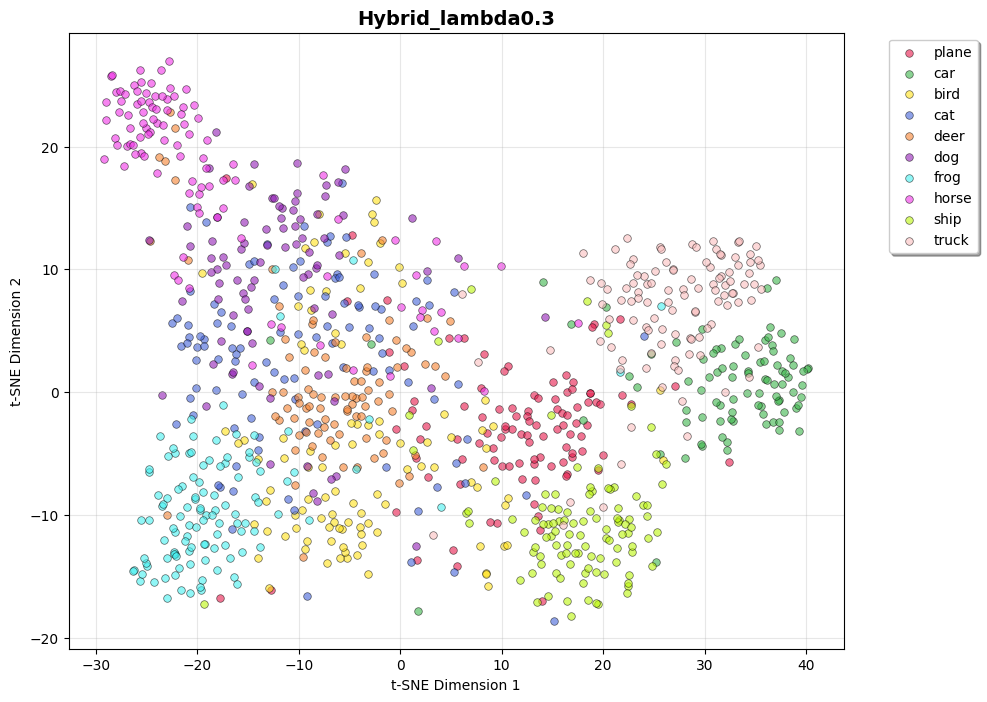


Loading Hybrid (λ=0.5) from pth_models/student_hybrid_lambda0.5.pth
  Train Acc (final): 90.60%
  ✓ λ=0.5: 74.33% (vs baseline: +0.97%)


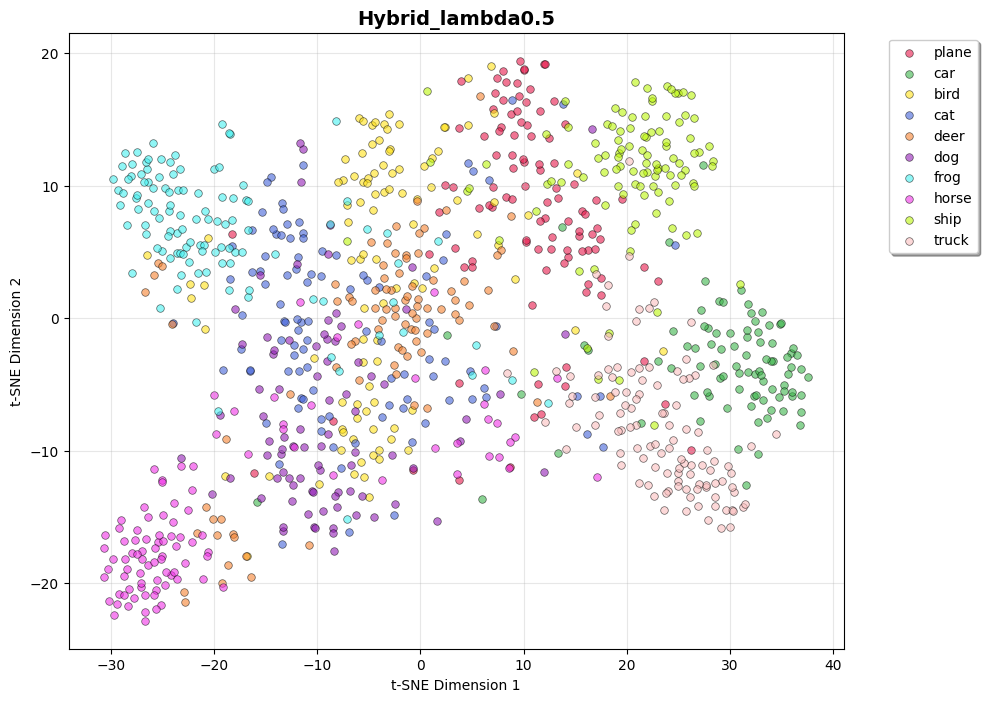


Loading Hybrid (λ=0.7) from pth_models/student_hybrid_lambda0.7.pth
  Train Acc (final): 92.18%
  ✓ λ=0.7: 74.14% (vs baseline: +0.78%)


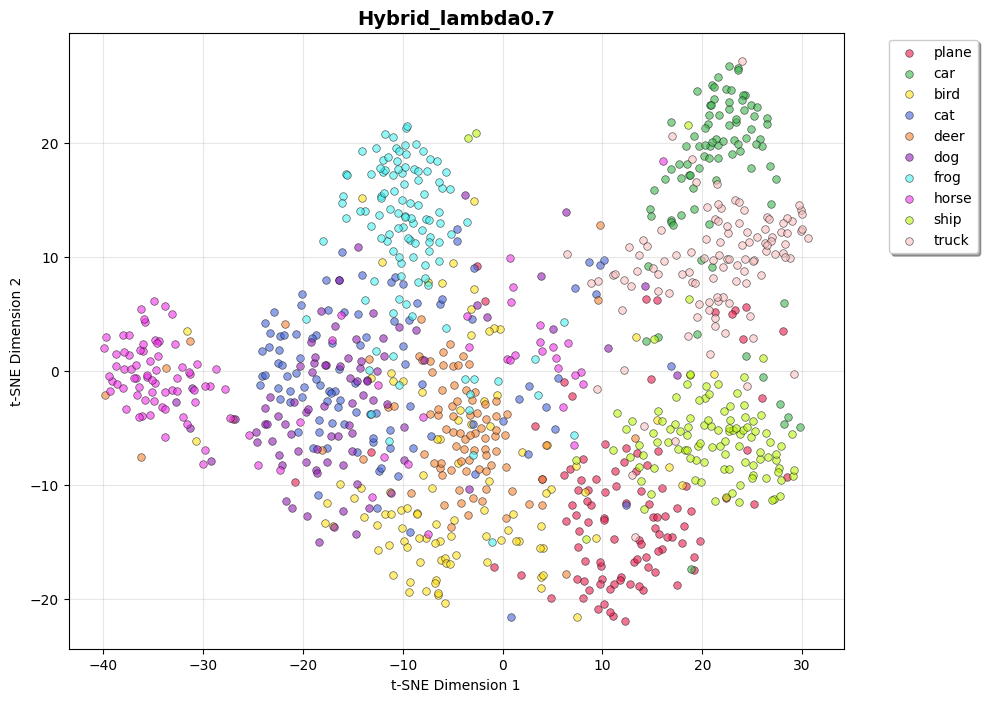


Loading Hybrid (λ=0.9) from pth_models/student_hybrid_lambda0.9.pth
  Train Acc (final): 92.81%
  ✓ λ=0.9: 74.90% (vs baseline: +1.54%)


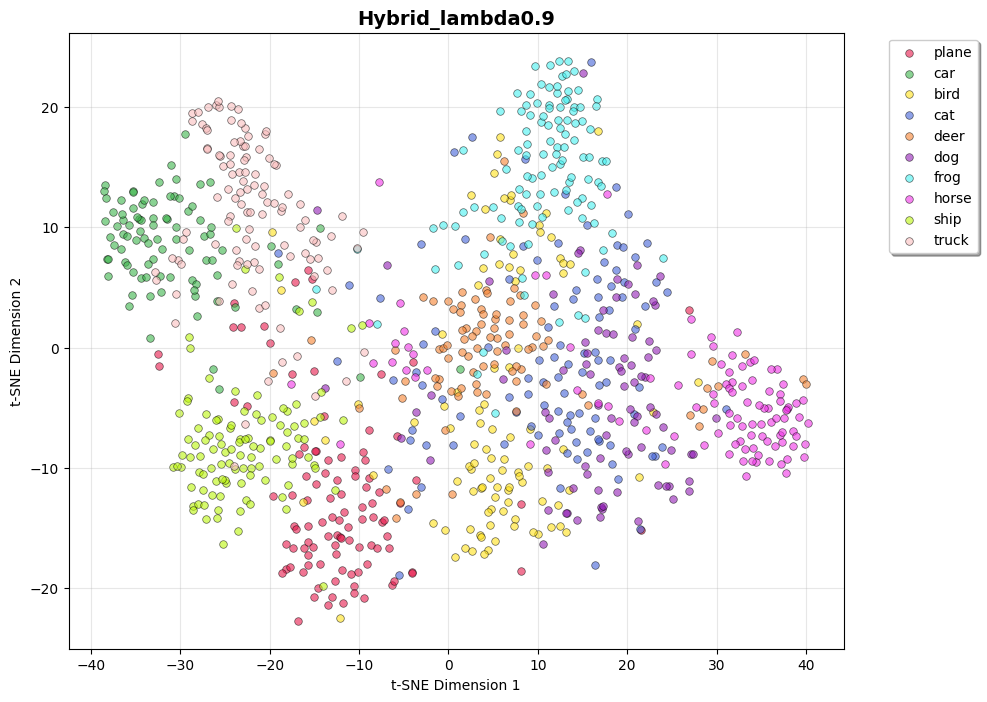


HYBRID RESULTS SUMMARY
λ=0.3  :  73.66% ( +0.30%) 🎯
λ=0.5  :  74.33% ( +0.97%) 🎯
λ=0.7  :  74.14% ( +0.78%) 🎯
λ=0.9  :  74.90% ( +1.54%) 🎯

Baseline: 73.36%


In [14]:
FORCE_RETRAIN_HYBRID = False
hybrid_results = {}

print("\n" + "="*100)
print("HYBRID LOSS SWEEP (α=1, β=12)")
print("="*100)

for lambda_val in LAMBDA_SWEEP:
    model_path = f'pth_models/student_hybrid_lambda{lambda_val}.pth'
    log_name = f'hybrid_lambda{lambda_val}'
    
    hybrid_log = load_training_log(log_name)
    if os.path.exists(model_path) and not FORCE_RETRAIN_HYBRID and hybrid_log:
        print(f"\nLoading Hybrid (λ={lambda_val}) from {model_path}")
        student = ModelWrapper(num_classes=num_classes).to(device)
        student.load_state_dict(torch.load(model_path, map_location=device))
        print(f"  Train Acc (final): {hybrid_log['train_acc'][-1]:.2f}%")
    else:
        student = ModelWrapper(num_classes=num_classes).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=LR)
        criterion = HybridSupCRDLoss(alpha=1.0, beta=12.0, 
                                     lambda_supcon=lambda_val, temperature=TEMP)
        student, hybrid_log = train_student(
            teacher, student, train_loader, optimizer, criterion, device,
            epochs=EPOCHS_STUDENT, label=f"Hybrid_λ{lambda_val}",
            mode='hybrid', log_name=log_name
        )
        torch.save(student.state_dict(), model_path)
    
    acc = evaluate_model(student, test_loader, device)
    hybrid_results[lambda_val] = acc
    print(f"  ✓ λ={lambda_val}: {acc:.2f}% (vs baseline: {acc - acc_baseline:+.2f}%)")
    visualize_latents(student, test_loader, device, title=f"Hybrid_lambda{lambda_val}")

print("\n" + "="*100)
print("HYBRID RESULTS SUMMARY")
print("="*100)
for lambda_val in sorted(hybrid_results.keys()):
    acc = hybrid_results[lambda_val]
    delta = acc - acc_baseline
    symbol = "🎯" if acc > acc_baseline else "✗"
    print(f"λ={lambda_val:<5}: {acc:>6.2f}% ({delta:>+6.2f}%) {symbol}")
print(f"\nBaseline: {acc_baseline:.2f}%")
print("="*100)

---
## ANALYSIS: Semantic Similarity Comparison

In [15]:
print("\n" + "="*100)
print("SEMANTIC SIMILARITY ANALYSIS")
print("="*100)

baseline_sim = compute_semantic_similarities(student_baseline, test_loader, device)

# Compare beta sweep models
for beta_val in [1.0, 10.0, 12.0]:
    if beta_val in beta_models:
        model_sim = compute_semantic_similarities(beta_models[beta_val], test_loader, device)
        compare_semantic_structure(baseline_sim, model_sim, class_names, 
                                  method_name=f"SupCRD (α=1, β={beta_val})")

# Compare balanced
balanced_sim = compute_semantic_similarities(student_balanced, test_loader, device)
compare_semantic_structure(baseline_sim, balanced_sim, class_names, 
                          method_name="Balanced SupCRD")

# Save matrices
np.save('json_results/baseline_similarity_matrix.npy', baseline_sim)
np.save('json_results/balanced_similarity_matrix.npy', balanced_sim)
print("\n✓ Saved similarity matrices")


SEMANTIC SIMILARITY ANALYSIS

SEMANTIC SIMILARITY: SupCRD (α=1, β=1.0)
Pair            | Baseline   | Method     | Δ Abs      | Δ %        | Quality
------------------------------------------------------------------------------------------
dog-cat         |    0.9464 |    0.9136 |   -0.0328 |     -3.5% | ✗ (want ↑)
dog-deer        |    0.7228 |    0.6202 |   -0.1027 |    -14.2% | ✗ (want ↑)
dog-car         |    0.2366 |    0.2946 |   +0.0580 |    +24.5% | ✗ (want ↓)
dog-truck       |    0.3211 |    0.3471 |   +0.0260 |     +8.1% | ✗ (want ↓)
plane-ship      |    0.7473 |    0.6977 |   -0.0496 |     -6.6% | ○ (want ~)
plane-bird      |    0.6498 |    0.5988 |   -0.0510 |     -7.8% | ○ (want ~)

SEMANTIC SIMILARITY: SupCRD (α=1, β=10.0)
Pair            | Baseline   | Method     | Δ Abs      | Δ %        | Quality
------------------------------------------------------------------------------------------
dog-cat         |    0.9464 |    0.9072 |   -0.0392 |     -4.1% | ✗ (want ↑)
dog-deer

---
## FINAL SUMMARY & EXPORT

In [16]:
print("\n" + "="*100)
print("COMPREHENSIVE EXPERIMENTAL SUMMARY")
print("="*100)

print(f"\nTeacher:              {acc_teacher:.2f}%")
print(f"Baseline SupCon:      {acc_baseline:.2f}%")
print(f"Balanced SupCRD:      {acc_balanced:.2f}% ({acc_balanced - acc_baseline:+.2f}%)")

print("\n--- Alpha Sweep Results (β=1) ---")
for alpha_val in sorted(alpha_results.keys()):
    print(f"  α={alpha_val:<5}: {alpha_results[alpha_val]:>6.2f}%")

print("\n--- Beta Sweep Results (α=1) ---")
for beta_val in sorted(beta_results.keys()):
    print(f"  β={beta_val:<5}: {beta_results[beta_val]:>6.2f}%")

print("\n--- Temperature Sweep Results ---")
for temp_val in sorted(temp_results.keys()):
    print(f"  τ={temp_val:<5}: {temp_results[temp_val]:>6.2f}%")

print("\n--- Hybrid Results ---")
best_hybrid_lambda = max(hybrid_results, key=hybrid_results.get)
for lambda_val in sorted(hybrid_results.keys()):
    marker = "★" if lambda_val == best_hybrid_lambda else " "
    print(f"  {marker} λ={lambda_val}: {hybrid_results[lambda_val]:>6.2f}%")

best_hybrid_acc = hybrid_results[best_hybrid_lambda]
if best_hybrid_acc > acc_baseline:
    print(f"\n🎯 SUCCESS: Hybrid (λ={best_hybrid_lambda}) beats baseline by {best_hybrid_acc - acc_baseline:.2f}%")
else:
    print(f"\n⚠️  Best hybrid (λ={best_hybrid_lambda}): {best_hybrid_acc - acc_baseline:+.2f}% vs baseline")

# Export all results
all_results = {
    'teacher': acc_teacher,
    'baseline_supcon': acc_baseline,
    'balanced_supcrd': acc_balanced,
    'alpha_sweep': alpha_results,
    'beta_sweep': beta_results,
    'temperature_sweep': temp_results,
    'hybrid_sweep': hybrid_results,
    'best_hybrid_lambda': best_hybrid_lambda,
    'best_hybrid_acc': best_hybrid_acc,
    'timestamp': datetime.now().isoformat()
}

with open('json_results/comprehensive_results.json', 'w') as f:
    json.dump(all_results, f, indent=2)

print("\n✓ Saved comprehensive results to json_results/comprehensive_results.json")
print("="*100)
print("✓ ALL EXPERIMENTS COMPLETE!")
print("="*100)


COMPREHENSIVE EXPERIMENTAL SUMMARY

Teacher:              75.58%
Baseline SupCon:      73.36%
Balanced SupCRD:      74.11% (+0.75%)

--- Alpha Sweep Results (β=1) ---
  α=1.0  :  73.95%
  α=2.0  :  75.38%
  α=3.0  :  74.42%
  α=4.0  :  74.32%
  α=5.0  :  73.91%
  α=10.0 :  72.55%
  α=50.0 :  74.09%

--- Beta Sweep Results (α=1) ---
  β=1.0  :  75.19%
  β=10.0 :  74.64%
  β=12.0 :  74.62%
  β=20.0 :  74.60%
  β=50.0 :  74.84%

--- Temperature Sweep Results ---
  τ=0.05 :  75.66%
  τ=0.07 :  75.62%
  τ=0.1  :  75.34%
  τ=0.15 :  75.02%

--- Hybrid Results ---
    λ=0.3:  73.66%
    λ=0.5:  74.33%
    λ=0.7:  74.14%
  ★ λ=0.9:  74.90%

🎯 SUCCESS: Hybrid (λ=0.9) beats baseline by 1.54%

✓ Saved comprehensive results to json_results/comprehensive_results.json
✓ ALL EXPERIMENTS COMPLETE!
